# AutoSleep Data 


In [12]:
import pandas as pd
import numpy as np 


# First we need to import our data from a csv file: 
df = pd.read_csv("AutoSleep.csv", header=0)


## Explore the Data & Handle Missing Values
* With this dataset, it appears that the nights I wasn't wearing my watch were not recorded so there are no missing values
* There are, however, `np.NaN` values in the columns tracking blood oxygen levels because my Apple Watch doesn't have that capability. 
    * Since this data is missing throughout the entire time interval of the dataset, I will be deleting those rows from the dataframe.
* This is nice except when I want to compare it so another source of data, it will be a little more difficult to combine 
without filling in the missing dates on the autosleep data or removing those dates from the other dataset. 


In [13]:
# What are the column names?
print(df.columns)
# It might be useful if I make a table that translates some of the column nates such as "ISO8601" and "qualityAvg7"

# print(df.head(5))
# print(df.tail(5))

# this for loop returns true if a column has any null values
for col in df:
    check_for_nan = df[col].isnull().values.any()
    if check_for_nan == True:
        print (col, check_for_nan, df[col].isnull().count())
        df.drop(col, axis=1, inplace=True)

print("after dropping empty columns:", df.head())

Index(['ISO8601', 'fromDate', 'toDate', 'bedtime', 'waketime', 'inBed',
       'awake', 'fellAsleepIn', 'sessions', 'asleep', 'asleepAvg7',
       'efficiency', 'efficiencyAvg7', 'quality', 'qualityAvg7', 'deep',
       'deepAvg7', 'sleepBPM', 'sleepBPMAvg7', 'dayBPM', 'dayBPMAvg7',
       'wakingBPM', 'wakingBPMAvg7', 'hrv', 'hrvAvg7', 'SpO2Avg', 'SpO2Min',
       'SpO2Max', 'respAvg', 'respMin', 'respMax', 'tags', 'notes'],
      dtype='object')
deep True 48
deepAvg7 True 48
dayBPM True 48
dayBPMAvg7 True 48
SpO2Avg True 48
SpO2Min True 48
SpO2Max True 48
respAvg True 48
respMin True 48
respMax True 48
tags True 48
notes True 48
after dropping empty columns:                      ISO8601                fromDate                  toDate  \
0  2022-01-28T20:59:59-08:00  Thursday, Jan 27, 2022    Friday, Jan 28, 2022   
1  2022-01-29T20:59:59-08:00    Friday, Jan 28, 2022  Saturday, Jan 29, 2022   
2  2022-01-30T20:59:59-08:00  Saturday, Jan 29, 2022    Sunday, Jan 30, 2022   
3  2022-02-

The following Columns have missing values for every instance in the dataset:
* deep 
* deepAvg7 
* dayBPM 
* dayBPMAvg7 
* SpO2Avg 
* SpO2Min 
* SpO2Max 
* respAvg 
* respMin 
* respMax 
* tags 
* notes 

## Now for some Summary Statistics: 
* Summarize the following into a pandas Series:
    * `nights_total` = total number nights logged
    * `avg_sleep` = average sleep 
    * `avg_[day]` = average sleep for each day of the week
    * `std_sleep` = standard deviation of sleep 
    * `std_[day]` = standard deviation for each day of the week
    * `mode_hours` = most common sleep length (rounded to the nearest hour)
    * `mode_day` = most common day of the week when mode sleep length occurred


In [14]:
# collecting summary statistics:
import utils 
import importlib
importlib.reload(utils)

summary_stats = []

# 1. total number of nights logged
nights_total = df.shape[0]
summary_stats.append(nights_total)

# 2. average hours slept
# we need to convert the timestamps into numeric values before we can calculate the mean
clean_df = utils.clean_sleep(df, "asleep")
sleep_ser = clean_df["asleep"]   
avg_sleep_secs = sleep_ser.mean()
avg_sleep = utils.sec_to_hours(avg_sleep_secs)
median_sleep_secs = sleep_ser.median()
median_sleep = utils.sec_to_hours(median_sleep_secs)
print("average time slept:", avg_sleep, "median:", median_sleep)
summary_stats.append(avg_sleep)

# 3. average sleep for each day of the week
days_of_week = utils.separate_days(df)
week_df = pd.DataFrame(days_of_week)
print(week_df)
avg_monday = utils.sec_to_hours(week_df["Monday"].dropna().mean())
avg_tuesday =  utils.sec_to_hours(week_df["Tuesday"].dropna().mean())
print("TUESDAY", avg_tuesday)
avg_wednesday =  utils.sec_to_hours(week_df["Wednesday"].dropna().mean())
avg_thursday =  utils.sec_to_hours(week_df["Thursday"].dropna().mean())
avg_friday =  utils.sec_to_hours(week_df["Friday"].dropna().mean())
avg_saturday =  utils.sec_to_hours(week_df["Saturday"].dropna().mean())
avg_sunday =  utils.sec_to_hours(week_df["Sunday"].dropna().mean())
summary_stats.append([avg_monday, avg_tuesday, avg_wednesday, avg_thursday, avg_friday, avg_saturday, avg_sunday])

# 4. standard deviation of sleep
std_sleep = utils.sec_to_hours(sleep_ser.std())
summary_stats.append(std_sleep)
print("STD:", std_sleep)

#5. standard deviation for each day of the week
std_mon = utils.sec_to_hours(week_df["Monday"].dropna().std())
std_tues = utils.sec_to_hours(week_df["Tuesday"].dropna().std())
std_wed = utils.sec_to_hours(week_df["Wednesday"].dropna().std())
std_thurs = utils.sec_to_hours(week_df["Thursday"].dropna().std())
std_fri = utils.sec_to_hours(week_df["Friday"].dropna().std())
std_sat = utils.sec_to_hours(week_df["Saturday"].dropna().std())
std_sun = utils.sec_to_hours(week_df["Sunday"].dropna().std())
summary_stats.append([std_mon, std_tues, std_wed, std_thurs, std_fri, std_sat, std_sun])


# 6. most common sleep length rounded to the nearest hour
ser = sleep_ser.copy()
for i in range(len(sleep_ser)):
    hours = round(sleep_ser[i]/3600, 0)
    ser[i] = hours
mode_hours = ser.mode()
print("mode", mode_hours) # 8.78 is about 8 hours and 45 minutes! 
summary_stats.append(mode_hours)

# 7. most common sleep length rounded to the nearest hour for each day 
mode_mon = utils.mode_mon(week_df).mode()
mode_tues = utils.mode_tues(week_df).mode()
mode_wed = utils.mode_wed(week_df).mode()
mode_thurs = utils.mode_wed(week_df).mode()
mode_fri = utils.mode_fri(week_df).mode()
mode_sat = utils.mode_sat(week_df).mode()
mode_sun = utils.mode_sun(week_df).mode()
print("mon", mode_mon, "tues", mode_tues, "wed", mode_wed, "thurs", mode_thurs, "fri", mode_fri, "sat", mode_sat, "sun", mode_sun)
mode_list = [mode_mon, mode_tues, mode_wed, mode_thurs, mode_fri, mode_sat, mode_sun]
print("***TYPE IS: ", type(mode_list))
print("Monday and Sunday nights are when I get the most common amount of hours of sleep: 9.0")


average time slept: ['7.0 hours 23.0 mins 18.75 seconds'] median: ['7.0 hours 46.0 mins 0.0 seconds']
    Monday  Tuesday  Wednesday  Thursday   Friday  Saturday   Sunday
0  25200.0  34020.0    22320.0   29460.0  39480.0     24300  26760.0
1  31680.0  23400.0    21600.0   16740.0  23940.0     30540  31980.0
2  35160.0  32400.0     9000.0   13980.0  28020.0     27900  18540.0
3  26340.0  24240.0    33540.0   12000.0  29580.0      4920  31620.0
4  32520.0  23640.0    24420.0   38460.0  35760.0     13680  28080.0
5  18120.0  21180.0        NaN   23820.0      NaN     40260  29940.0
6      NaN  25260.0        NaN   30780.0      NaN     29160  32460.0
7      NaN      NaN        NaN   27840.0      NaN     30180  31620.0
8      NaN      NaN        NaN       NaN      NaN     30900      NaN
TUESDAY ['7.0 hours 18.0 mins 25.714285714286234 seconds']
STD: ['2.0 hours 7.0 mins 25.636114526029814 seconds']
mode 0    9.0
dtype: object
mon 0    7.0
1    9.0
dtype: float64 tues 0    7.0
dtype: float64 

### Plotting the summary statistics:

,ISO8601,fromDate,toDate,bedtime,waketime,inBed,awake,fellAsleepIn,sessions,asleep,...,efficiency,efficiencyAvg7,quality,qualityAvg7,sleepBPM,sleepBPMAvg7,wakingBPM,wakingBPMAvg7,hrv,hrvAvg7
0,2022-01-28T20:59:59-08:00,"Thursday, Jan 27, 2022","Friday, Jan 28, 2022",2022-01-27 22:46:00,2022-01-28 07:03:00,08:17:00,00:06:00,00:00:00,1,29460,...,98.8,98.8,06:31:06,06:31:06,55.5,55.5,52.0,52.0,54,54
1,2022-01-29T20:59:59-08:00,"Friday, Jan 28, 2022","Saturday, Jan 29, 2022",2022-01-28 23:00:00,2022-01-29 10:50:00,11:50:00,00:52:00,00:00:00,1,39480,...,92.7,95.7,08:16:04,07:23:35,57.4,56.4,55.0,53.5,76,65
2,2022-01-30T20:59:59-08:00,"Saturday, Jan 29, 2022","Sunday, Jan 30, 2022",2022-01-30 03:34:04,2022-01-30 10:30:00,06:55:55,00:10:55,00:10:55,1,24300,...,97.4,96.3,05:52:30,06:53:13,58.4,57.1,56.0,54.3,59,63
3,2022-02-06T20:59:59-08:00,"Saturday, Feb 5, 2022","Sunday, Feb 6, 2022",2022-02-06 01:15:00,2022-02-06 09:44:00,08:29:00,00:00:00,00:00:00,1,30540,...,100.0,97.2,06:48:05,06:51:56,62.7,58.5,71.0,58.5,75,66
4,2022-02-07T20:59:59-08:00,"Sunday, Feb 6, 2022","Monday, Feb 7, 2022",2022-02-06 23:00:00,2022-02-07 06:32:00,07:32:00,00:06:00,00:00:00,1,26760,...,98.7,97.5,06:06:28,06:42:51,59.9,58.8,57.0,58.2,102,73


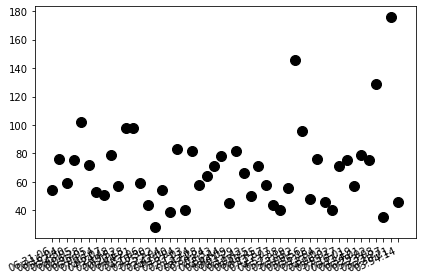

In [23]:
import matplotlib.pyplot as plt

def scatter_chart_example(x_ser, y_ser):
    plt.figure()    # creates a NEW CURRENT FIGURE
    plt.scatter(x_ser, y_ser, color="black", s=100)
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
